# Beta distribution

In [ ]:
from scipy import stats

from src.utils.utils import flatten_recursive
from src.stats_comp import compatibility_corpus

def beta_variable(successes, failures):
    n = successes
    m = failures

    a, b = n + 1, m + 1

    X = stats.beta(a, b)  # Declare X to be a beta random variable

    return X

all_corpus_comp_scores = compatibility_corpus('data/compiled/triads')
all_corpus_comp_baseline_scores = compatibility_corpus('data/compiled/baselines/triads/prose')

outcomes = list(flatten_recursive(all_corpus_comp_scores))
outcomes_baseline = list(flatten_recursive(all_corpus_comp_baseline_scores))

# Normalize the outcomes to be between 0 and 1
min_outcome = min(outcomes)
max_outcome = max(outcomes)
normalized_outcomes = [(outcome - min_outcome) / (max_outcome - min_outcome) for outcome in outcomes]
print(f"Normalized outcomes: {normalized_outcomes}")

min_outcome_baseline = min(outcomes_baseline)
max_outcome_baseline = max(outcomes_baseline)
normalized_outcomes_baseline = [(outcome - min_outcome_baseline) / (max_outcome_baseline - min_outcome_baseline) for outcome in outcomes_baseline]
print(f"Normalized baseline outcomes: {normalized_outcomes_baseline}")

# Bayesian testing assuming Beta distribution

# Step 1: Laplace prior

Prior = beta_variable(1, 1)

# Step 2: Update with data

successes = sum(1 for outcome in normalized_outcomes if outcome >= 0.5)
print(f"Successes: {successes}")
failures = len(normalized_outcomes) - successes

Posterior = beta_variable(successes, failures)

successes_baseline = sum(1 for outcome in normalized_outcomes_baseline if outcome >= 0.5)
print(f"Baseline Successes: {successes_baseline}")
failures_baseline = len(normalized_outcomes_baseline) - successes_baseline

Posterior_baseline = beta_variable(successes_baseline, failures_baseline)

# Step 3: Analyze

mean_prior = Prior.mean()
credibility_interval_prior = Prior.interval(0.95)

mean_posterior = Posterior.mean()
variance_posterior = Posterior.var()
skewness_posterior = Posterior.stats(moments='s')
kurtosis_posterior = Posterior.stats(moments='k')
credibility_interval = Posterior.interval(0.95)

mean_posterior_baseline = Posterior_baseline.mean()
variance_posterior_baseline = Posterior_baseline.var()
skewness_posterior_baseline = Posterior_baseline.stats(moments='s')
kurtosis_posterior_baseline = Posterior_baseline.stats(moments='k')
credibility_interval_baseline = Posterior_baseline.interval(0.95)

# Plot results

print("Prior Results:")
print(f"\tMean of Posterior: {mean_posterior}")
print(f"\tVariance of Posterior: {variance_posterior}")
print(f"\tSkewness of Posterior: {skewness_posterior}")
print(f"\tKurtosis (thickness of tails) of Posterior: {kurtosis_posterior}")
print(f"\t95% Credibility Interval: {credibility_interval}")

print("Baseline Results:")
print(f"\tMean of Posterior Baseline: {mean_posterior_baseline}")
print(f"\tVariance of Posterior Baseline: {variance_posterior_baseline}")
print(f"\tSkewness of Posterior Baseline: {skewness_posterior_baseline}")
print(f"\tKurtosis (thickness of tails) of Posterior Baseline: {kurtosis_posterior_baseline}")
print(f"\t95% Credibility Interval Baseline: {credibility_interval_baseline}")

# Plot the prior and the two posterior distributions
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)
y_prior = Prior.pdf(x)
y_posterior = Posterior.pdf(x)
y_posterior_baseline = Posterior_baseline.pdf(x)

plt.plot(x, y_prior, label='Prior', linestyle='--')
plt.plot(x, y_posterior, label='Posterior', color='blue')
plt.plot(x, y_posterior_baseline, label='Posterior Baseline', color='orange')
plt.fill_between(x, 0, y_posterior, where=(x >= credibility_interval[0]) & (x <= credibility_interval[1]), color='blue', alpha=0.3)
plt.fill_between(x, 0, y_posterior_baseline, where=(x >= credibility_interval[0]) & (x <= credibility_interval[1]), color='orange', alpha=0.3)
plt.title('Prior and Posterior Distributions')
plt.xlabel('Compatibility Score')
plt.ylabel('Density')
plt.legend()
plt.show()

Processing all odes...


100%|██████████| 40/40 [00:01<00:00, 33.40it/s]


Creating plots...


100%|██████████| 40/40 [00:00<00:00, 356.97it/s]



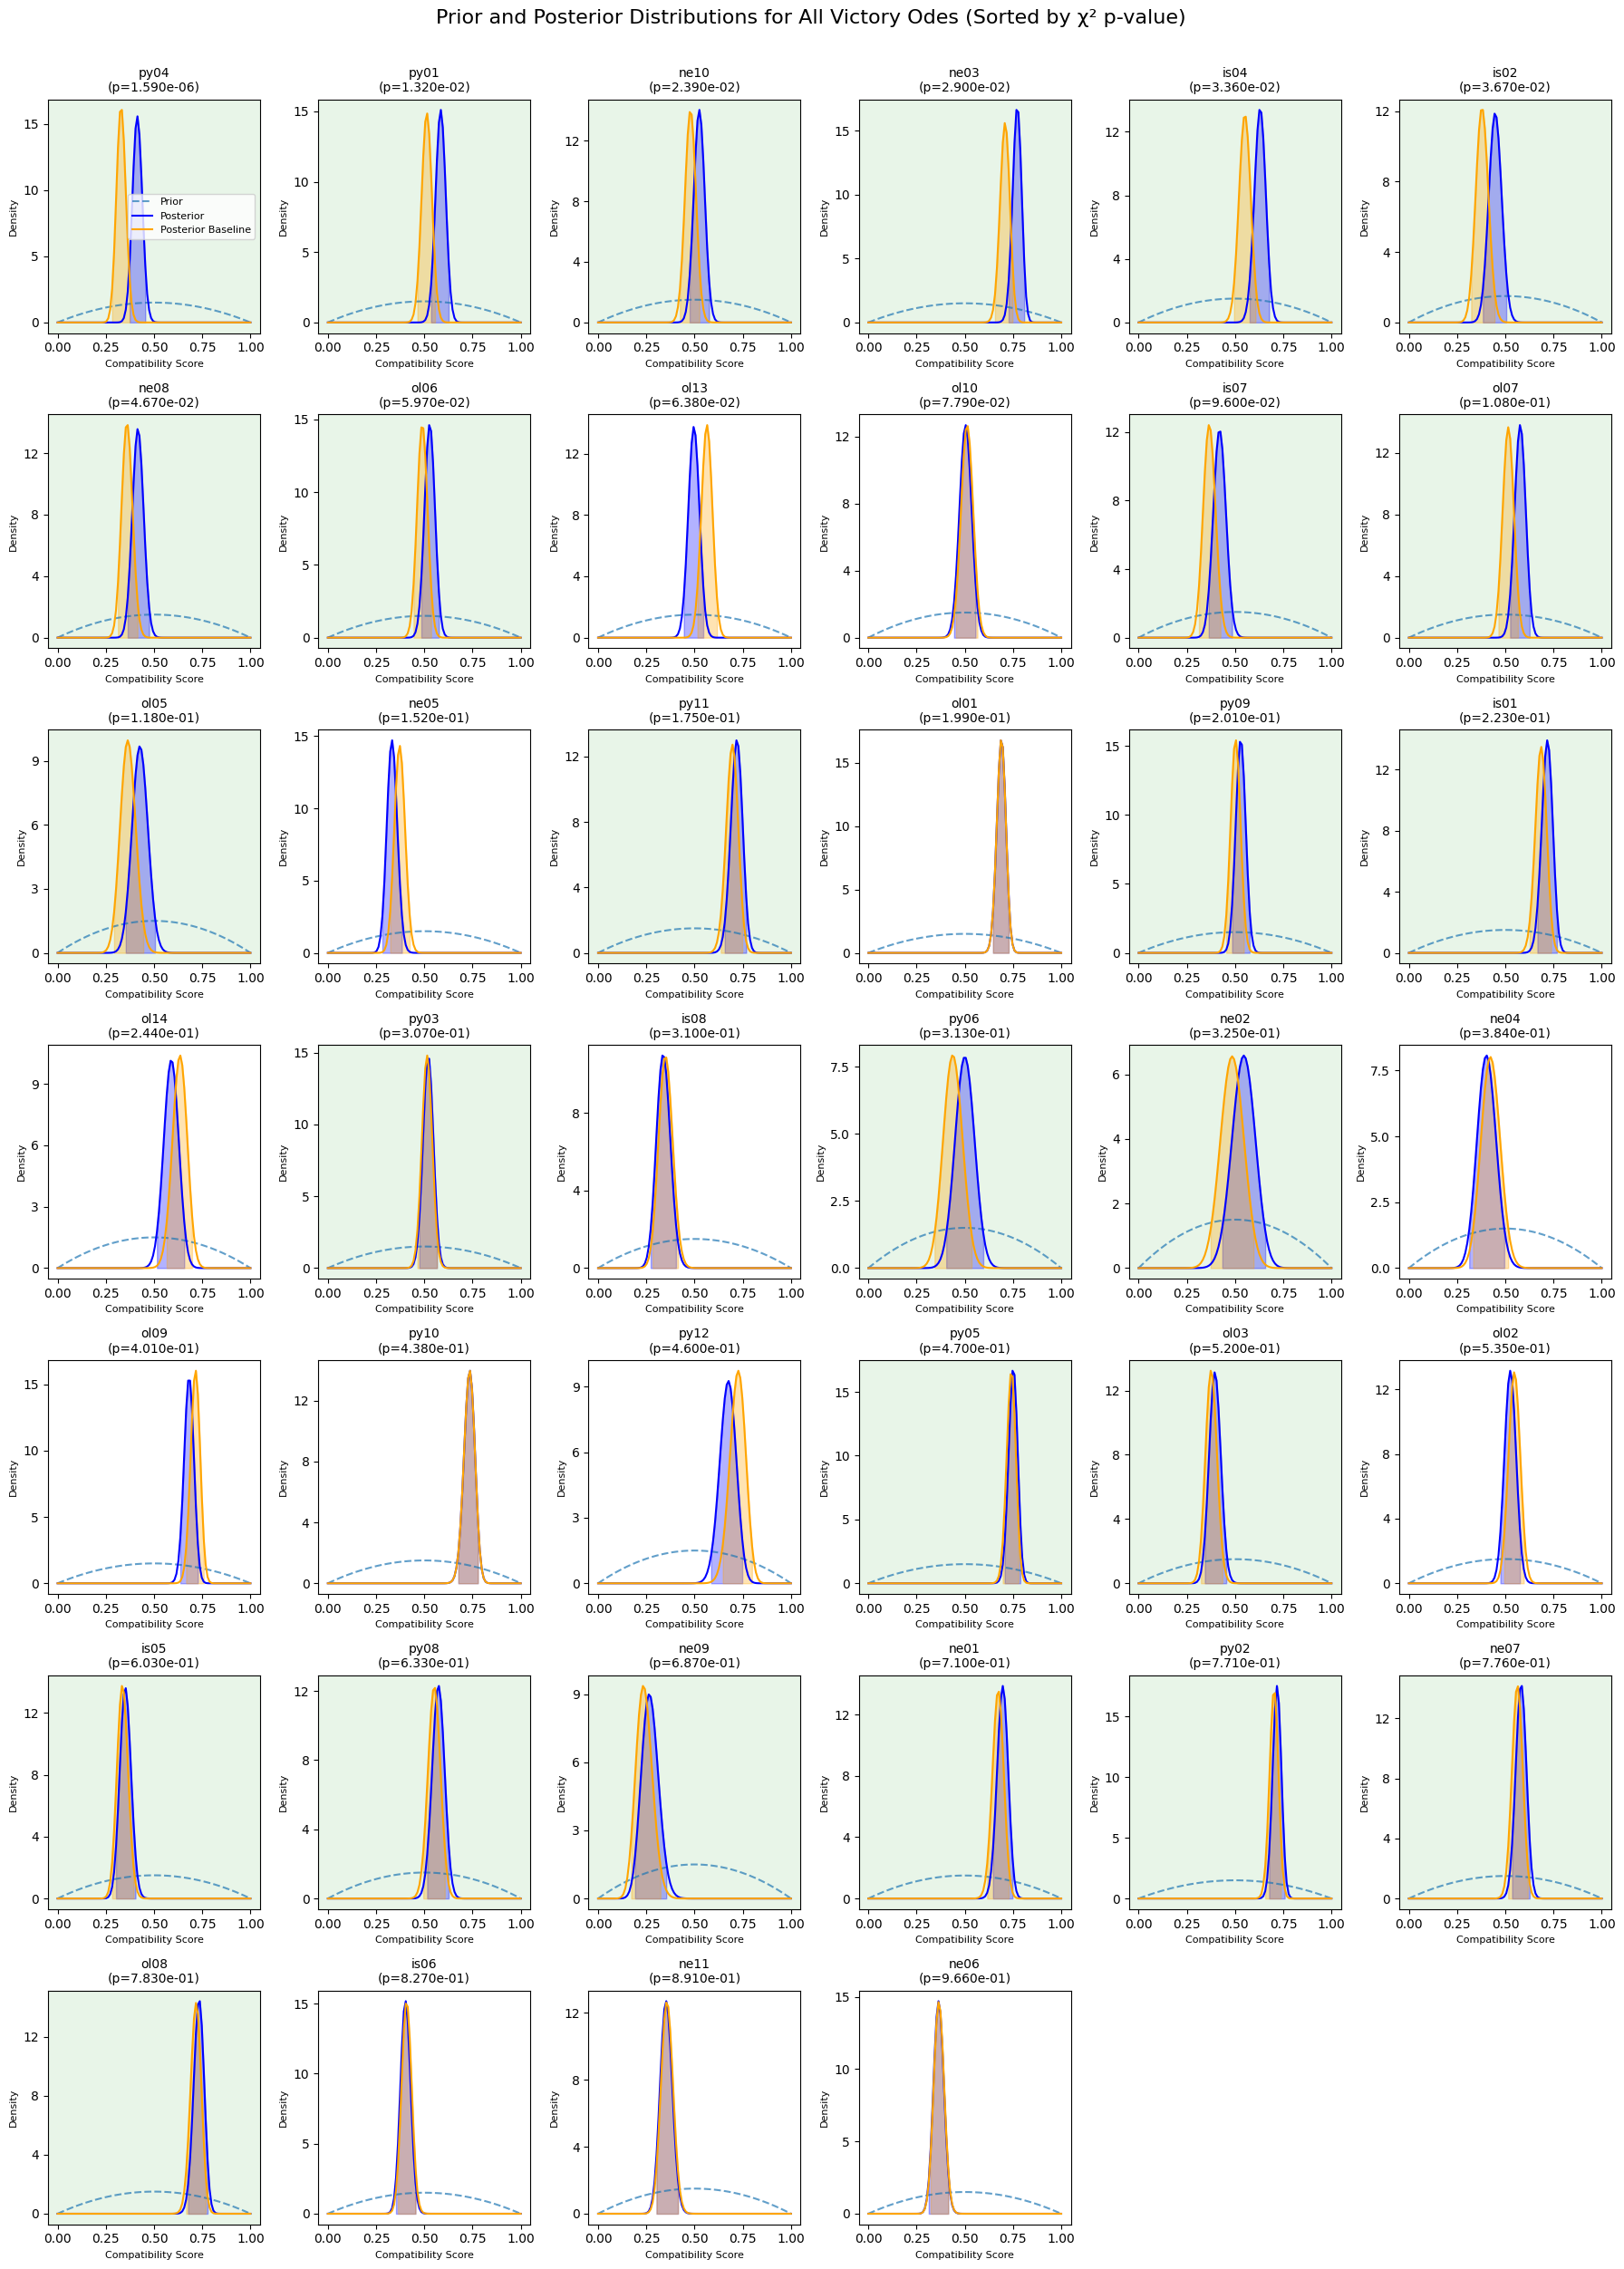

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

from src.utils.utils import flatten_recursive
from src.stats_comp import compatibility_play, compatibility_canticum
from results import victory_odes, ode_chisquare

def beta_variable(successes, failures):
    n = successes
    m = failures
    a, b = n + 1, m + 1
    X = stats.beta(a, b)
    return X

def process_ode_data(responsion_attribute):
    """Process a single ode and return all needed data"""
    # Load data based on ode prefix
    if responsion_attribute[:2] == "ol":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_olympians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "py":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_pythians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "ne":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_nemeans_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "is":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_isthmians_triads.xml', responsion_attribute)

    all_comp_baseline_scores = compatibility_play(f'data/compiled/baselines/triads/prose/baseline_prose_{responsion_attribute}.xml')

    outcomes = list(flatten_recursive(all_comp_scores))
    outcomes_baseline = list(flatten_recursive(all_comp_baseline_scores))

    # Normalize outcomes
    min_outcome = min(outcomes)
    max_outcome = max(outcomes)
    normalized_outcomes = [(outcome - min_outcome) / (max_outcome - min_outcome) for outcome in outcomes]

    min_outcome_baseline = min(outcomes_baseline)
    max_outcome_baseline = max(outcomes_baseline)
    normalized_outcomes_baseline = [(outcome - min_outcome_baseline) / (max_outcome_baseline - min_outcome_baseline) for outcome in outcomes_baseline]

    # Calculate posteriors
    successes = sum(1 for outcome in normalized_outcomes if outcome >= 0.5)
    failures = len(normalized_outcomes) - successes
    Posterior = beta_variable(successes, failures)

    successes_baseline = sum(1 for outcome in normalized_outcomes_baseline if outcome >= 0.5)
    failures_baseline = len(normalized_outcomes_baseline) - successes_baseline
    Posterior_baseline = beta_variable(successes_baseline, failures_baseline)

    # Calculate difference for sorting
    mean_diff = Posterior.mean() - Posterior_baseline.mean()

    chisquare_pvalue = ode_chisquare[responsion_attribute][2]
    
    return {
        'responsion_attribute': responsion_attribute,
        'mean_diff': mean_diff,
        'Posterior': Posterior,
        'Posterior_baseline': Posterior_baseline,
        'normalized_outcomes': normalized_outcomes,
        'normalized_outcomes_baseline': normalized_outcomes_baseline,
        'chisquare_pvalue': chisquare_pvalue
    }

# Process all odes once and store results
print("Processing all odes...")
ode_data = []
for responsion_attribute in tqdm(victory_odes):
    data = process_ode_data(responsion_attribute)
    ode_data.append(data)

# Sort by chi-square p-value (ascending order - most significant first)
sorted_ode_data = sorted(ode_data, key=lambda x: x['chisquare_pvalue'])

# Calculate subplot layout
n_plots = len(sorted_ode_data)
n_cols = 6
n_rows = (n_plots + n_cols - 1) // n_cols

# Create plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3.5 * n_rows))
axes = axes.flatten()

print("Creating plots...")
for i, data in enumerate(tqdm(sorted_ode_data)):
    responsion_attribute = data['responsion_attribute']
    Posterior = data['Posterior']
    Posterior_baseline = data['Posterior_baseline']
    mean_diff = data['mean_diff']
    chisquare_pvalue = data['chisquare_pvalue']
    
    # Create prior for plotting
    Prior = beta_variable(1, 1)
    
    # Calculate intervals
    credibility_interval = Posterior.interval(0.95)
    credibility_interval_baseline = Posterior_baseline.interval(0.95)
    
    # Plot on current subplot
    ax = axes[i]
    
    # Set light green background if posterior mean > baseline mean
    if Posterior.mean() > Posterior_baseline.mean():
        ax.set_facecolor('#e8f5e8')
    
    x = np.linspace(0, 1, 100)
    y_prior = Prior.pdf(x)
    y_posterior = Posterior.pdf(x)
    y_posterior_baseline = Posterior_baseline.pdf(x)

    ax.plot(x, y_prior, label='Prior', linestyle='--', alpha=0.7)
    ax.plot(x, y_posterior, label='Posterior', color='blue')
    ax.plot(x, y_posterior_baseline, label='Posterior Baseline', color='orange')
    ax.fill_between(x, 0, y_posterior, where=(x >= credibility_interval[0]) & (x <= credibility_interval[1]), color='blue', alpha=0.3)
    ax.fill_between(x, 0, y_posterior_baseline, where=(x >= credibility_interval_baseline[0]) & (x <= credibility_interval_baseline[1]), color='orange', alpha=0.3)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.set_title(f"{responsion_attribute}\n(p={chisquare_pvalue:.3e})", fontsize=10)
    ax.set_xlabel('Compatibility Score', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    
    if i == 0:
        ax.legend(fontsize=8)

# Hide empty subplots
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Prior and Posterior Distributions for All Victory Odes (Sorted by χ² p-value)', fontsize=16, y=1.02)
plt.show()

# χ-square tests

In [ ]:
from src.stats_comp import compatibility_corpus
from src.utils.utils import make_chisquare_test

all_corpus_comp_scores = compatibility_corpus('data/compiled/triads')
all_corpus_comp_baseline_scores = compatibility_corpus('data/compiled/baselines/triads/prose')

# Output
chi2_stat, degrees_of_freedom, p_value, sorted_keys, obs_counts, obs_total, exp_counts = make_chisquare_test(all_corpus_comp_scores, all_corpus_comp_baseline_scores)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"P-value: {p_value:.3e}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------ #
# Visualize distributions        #
# ------------------------------ #

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Bar chart comparing observed vs expected
x_pos = np.arange(len(sorted_keys))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, obs_counts, width, label='Observed', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, exp_counts, width, label='Expected', alpha=0.8)

ax1.set_xlabel('Compatibility Categories')
ax1.set_ylabel('Counts')
ax1.set_title('Observed vs Expected Distributions')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(sorted_keys, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals (contribution to chi-square)
residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
colors = ['red' if r > 0 else 'blue' for r in residuals]

bars3 = ax2.bar(x_pos, residuals, color=colors, alpha=0.7)
ax2.set_xlabel('Compatibility Categories')
ax2.set_ylabel('Standardized Residuals')
ax2.set_title('Standardized Residuals (Contribution to χ²)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sorted_keys, rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------ #
# Additional analysis            #
# ------------------------------ #

# Calculate standardized residuals and contributions
std_residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
chi2_contributions = std_residuals**2

# Create a summary table
print("\nContribution Analysis:")
print("-" * 60)
for i, key in enumerate(sorted_keys):
    print(f"{key:>15}: Obs={obs_counts[i]:4d}, Exp={exp_counts[i]:6.1f}, "
          f"Residual={std_residuals[i]:6.2f}, Contrib={chi2_contributions[i]:6.2f}")

print(f"\nSum of contributions: {chi2_contributions.sum():.4f}")
print(f"Chi-square statistic: {chi2_stat:.4f}")

# Calculate Cramér's V (effect size)
n = obs_total
k = len(sorted_keys)
cramers_v = np.sqrt(chi2_stat / (n * (k - 1)))
print(f"Cramér's V (effect size): {cramers_v:.4f}")

## For each canticum

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.stats_comp import compatibility_play, compatibility_canticum
from src.utils.utils import make_chisquare_test

from results import victory_odes

chisquare_dict = {}
for responsion_attribute in tqdm(victory_odes):
    if responsion_attribute[:2] == "ol":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_olympians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "py":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_pythians_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "ne":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_nemeans_triads.xml', responsion_attribute)
    elif responsion_attribute[:2] == "is":
        all_comp_scores = compatibility_canticum('data/compiled/triads/ht_isthmians_triads.xml', responsion_attribute)

    all_comp_baseline_scores = compatibility_play(f'data/compiled/baselines/triads/prose/baseline_prose_{responsion_attribute}.xml')

    # Output
    chi2_stat, degrees_of_freedom, p_value, sorted_keys, obs_counts, obs_total, exp_counts = make_chisquare_test(all_comp_scores, all_comp_baseline_scores)
    
    # Convert NumPy types to native Python types INSIDE the loop
    chisquare_dict[responsion_attribute] = (
        float(chi2_stat),           # Convert np.float64 to float
        int(degrees_of_freedom),    # Convert to int
        float(p_value),            # Convert np.float64 to float
        list(sorted_keys),          # Ensure it's a list
        obs_counts.tolist(),       # Convert numpy array to list
        int(obs_total),            # Convert np.int64 to int
        exp_counts.tolist()        # Convert numpy array to list
    )

    # ------------------------------ #
    # Visualize distributions        #
    # ------------------------------ #

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Bar chart comparing observed vs expected
    x_pos = np.arange(len(sorted_keys))
    width = 0.35

    bars1 = ax1.bar(x_pos - width/2, obs_counts, width, label='Observed', alpha=0.8)
    bars2 = ax1.bar(x_pos + width/2, exp_counts, width, label='Expected', alpha=0.8)

    ax1.set_xlabel('Compatibility Categories')
    ax1.set_ylabel('Counts')
    ax1.set_title(f'Observed vs Expected Distributions for {responsion_attribute}')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(sorted_keys, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Residuals (contribution to chi-square)
    residuals = (obs_counts - exp_counts) / np.sqrt(exp_counts)
    colors = ['red' if r > 0 else 'blue' for r in residuals]

    bars3 = ax2.bar(x_pos, residuals, color=colors, alpha=0.7)
    ax2.set_xlabel('Compatibility Scores')
    ax2.set_ylabel('Standardized Residuals')
    ax2.set_title(f'Standardized Residuals for {responsion_attribute} (Contribution to χ²)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sorted_keys, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'media/significance/chisquare_{responsion_attribute}.png')







# # Write to file with consistent formatting
# with open("results.py", "a", encoding="utf-8") as f:
#     f.write("\node_chisquare = {\n")
#     for key, value in chisquare_dict.items():
#         chi2_stat, dof, p_val, keys, obs, total, exp = value
#         f.write(f"    '{key}': ({chi2_stat:.6f}, {dof}, {p_val:.2e}, "
#                 f"{keys}, {obs}, {total}, {exp}),\n")
#     f.write("}\n")